In [5]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [6]:
np.random.seed(1234)
tf.random.set_seed(1234)

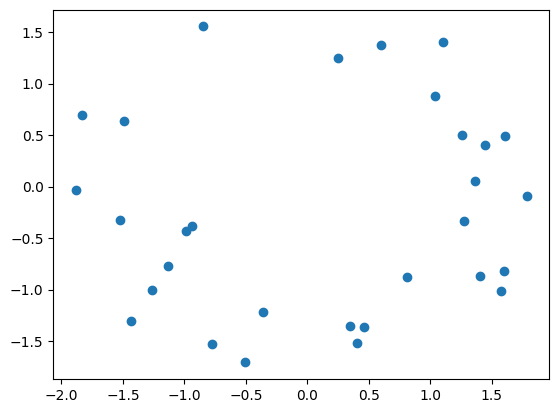

In [7]:
r = np.random.random(30) + 1
theta = np.random.random(30)*2*np.pi

x0 = 0
y0 = 0

x = x0 + r*np.cos(theta)
y = y0 + r*np.sin(theta)

plt.scatter(x,y)

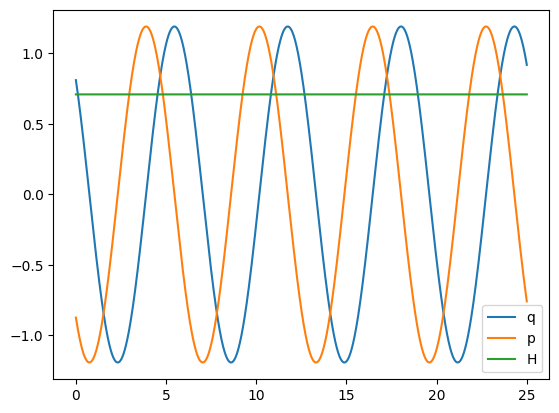

In [8]:
m =1
k = 1
omega = np.sqrt(m/k)
t = np.linspace(0,25,2501)
q = x[0]*np.cos(omega*t) + y[0]*np.sin(omega*t)
p = (-x[0]*np.sin(omega*t) + y[0]*np.cos(omega*t))*omega
plt.plot(t,q)
plt.plot(t,p)
plt.plot(t,0.5*(p**2 + q**2))
plt.legend(['q','p','H'])

In [9]:
Q = np.zeros((30,2501))
P = np.zeros((30,2501))
T = np.zeros((30,2501))
for i in range(30):
  Q[i] = x[i]*np.cos(omega*t) + y[i]*np.sin(omega*t)
  P[i] = (-x[i]*np.sin(omega*t) + y[i]*np.cos(omega*t))*omega
  T[i] = t
print(f"Shape of Q is {Q.shape}")
print(f"Shape of P is {P.shape}")

Shape of Q is (30, 2501)
Shape of P is (30, 2501)


In [10]:
window_size = 5
num_windows = 2501//window_size
remainder = (2501 - 1)%window_size
if remainder!=0:  
  Q_truncated = Q[:,:-remainder]
else:
  Q_truncated = Q

Q_inp = Q_truncated[:,:-1]
Q_inp = Q_inp.reshape((-1, window_size))

Q_tru = Q_truncated[:,1:]
Q_tru = Q_tru.reshape((-1, window_size))

if remainder!=0:
  P_truncated = P[:,:-remainder]
else:
  P_truncated = P

P_inp = P_truncated[:,:-1]
P_inp = P_inp.reshape((-1,window_size))

P_tru = P_truncated[:,1:]
P_tru = P_tru.reshape((-1,window_size))

In [11]:
print(Q_tru.shape)
print(Q_inp.shape)

print(P_tru.shape)
print(P_inp.shape)

PQ_tru = np.stack((Q_tru,P_tru),axis = -1)
PQ_inp = np.stack((Q_inp,P_inp),axis = -1)
print(PQ_tru.shape)
print(PQ_inp.shape)

(15000, 5)
(15000, 5)
(15000, 5)
(15000, 5)
(15000, 5, 2)
(15000, 5, 2)


In [12]:
class LSTM_model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.lstm = tf.keras.layers.LSTM(100, return_sequences=True)
    self.dense = tf.keras.layers.Dense(2)

  def call(self, inputs):
    x = self.lstm(inputs)
    output = self.dense(x)
    return output

  def loss(self, predictions, truth):
    return tf.reduce_mean((predictions-truth)**2)

In [13]:
model = LSTM_model()
input = tf.random.normal([32,10,2]) #batch_sz, window_sz, num_features
output = model(input)

In [14]:
model.summary()
print(output.shape)

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  41200     
                                                                 
 dense (Dense)               multiple                  202       
                                                                 
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________
(32, 10, 2)


In [15]:
model = LSTM_model()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 100
batch_size = 512
num_batches = PQ_inp.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
    batch_loss = []   
    for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
        y_pred = model.call(PQ_inp[start:end,:,:])
        loss = model.loss(y_pred, PQ_tru[start:end,:,:])

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
    loss_list.append(sum(batch_loss)/len(batch_loss))
    if i % 10 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.7153982520103455
Loss on training set after 10 training steps: 0.011222193017601967
Loss on training set after 20 training steps: 0.0003202961524948478
Loss on training set after 30 training steps: 0.0002201912138843909
Loss on training set after 40 training steps: 0.00016479111218359321
Loss on training set after 50 training steps: 0.0001248296321136877
Loss on training set after 60 training steps: 9.42728656809777e-05
Loss on training set after 70 training steps: 7.008697866695002e-05
Loss on training set after 80 training steps: 5.232691910350695e-05
Loss on training set after 90 training steps: 4.0330713090952486e-05


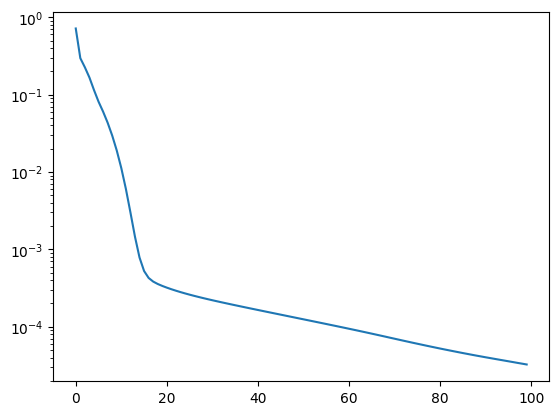

In [18]:
plt.semilogy(loss_list)

126.51270064022356
1.5319011724496763
119.21863552818594
1.7061920848413519
137.37905438445824
1.535744084770287
117.93985433238599
1.7909027775049324
125.80380961245667
1.604218665523475
1.6337917570179443


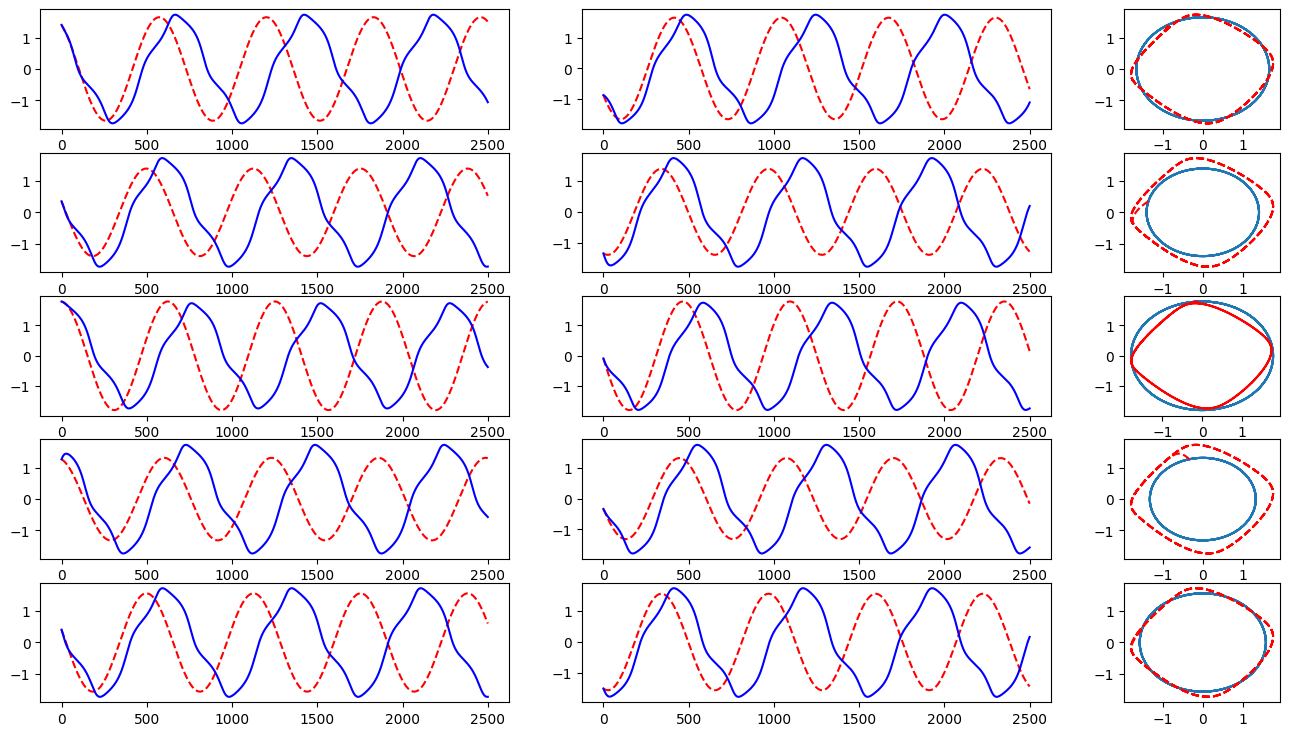

<Figure size 640x480 with 0 Axes>

In [21]:
fig, ax = plt.subplots(5,3, figsize = (16,9),gridspec_kw={'width_ratios': [3,3,1]})

test_err_sum = []
for j in range(0,5):
  q_list = []
  p_list = []
  x0 = Q[j+25,0]
  y0 = P[j+25,0]
  q_list.append(x0)
  p_list.append(y0)
  for i in range(2500):
    inp = tf.convert_to_tensor(np.array([[[x0,y0]]]))
    out = model.call(inp).numpy()
    x0 = out[0,0,0]
    y0 = out[0,0,1]
    q_list.append(x0)
    p_list.append(y0)
  q = Q[j+25,:]
  p = P[j+25,:]
  ax[j,0].plot(q,'--r')
  ax[j,0].plot(q_list,'b')
  ax[j,1].plot(p,'--r')
  ax[j,1].plot(p_list,'b')
  ax[j,2].plot(p,q)
  ax[j,2].plot(p_list,q_list,'--r')
  l2 = np.sqrt(np.sum((np.array(q_list) - Q[j+25,:])**2 + np.array(p_list -P[j+25,:])**2))
  l2or = np.sqrt(np.sum((Q[j+25])**2 + np.array(P[j+25])**2))
  print(l2)
  print(l2/l2or)
  test_err_sum.append(l2/l2or)
plt.figure()
print(np.mean(np.array(test_err_sum)))

In [20]:
np.mean(np.array(test_err_sum))

1.6337917570179443